In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv
import unidecode
import os
import numpy as np
import zlib
import dateutil
import datetime
from ipywidgets import widgets, interactive_output
from IPython.display import display
import random
import itertools


# Lectura de Tablas

In [ ]:
# Lista con los nombres de los archivos csv de la tablas
names = [os.path.splitext(i)[0] for i in os.listdir("data") if os.path.splitext(i)[0].startswith("df")]

# Lectura de las tablas
for i in names:
  # Lectura de cronicos
  if i.endswith("cronicos"):
    # Crear DataFrame
    df = pd.read_csv(f'data/{i}.csv', delimiter=";", encoding="latin-1", low_memory=False)

    # Cambiar caracteres especiales de las columnas
    with open(f'data/{i}.csv', "r", encoding="utf-8") as f:
      # Leer primera fila (nombre de columnas)
      text = csv.reader(f)
      # Crear variable
      columns = next(text)

    # Remover caracteres especiales
    columns = unidecode.unidecode(columns[0]).split(";")
    # Cambiar nombre de columnas en el DataFrame
    df.columns = columns
    # Reemplazar valores sin informacion por valores nulos
    df.replace(["", "([sS]in\s)", "ND"], [np.nan]*3, regex=True, inplace=True)
    # Crear variables locales de los diferentes DataFrames
    locals().update({i:df})

  # Lectura usuarios y egresos
  else:
    # Crear DataFrame
    df = pd.read_csv(f'data/{i}.csv', delimiter=",", encoding="latin-1", low_memory=False)

    # Cambiar caracteres especiales de las columnas
    with open(f'data/{i}.csv', "r", encoding="utf-8") as f:
      # Leer primera fila (nombre de columnas)
      text = csv.reader(f)
      # Crear variable
      columns = next(text)
      # rows = np.array([unidecode.unidecode(";".join(i)).split(";") for i in text])

    # Remover caracteres especiales
    columns = unidecode.unidecode(";".join(columns)).split(";")
    # dic = {j:rows[:,i] for i,j in enumerate(columns)}
    # df = pd.DataFrame(dic)
    # Cambiar nombre de columnas en el DataFrame
    df.columns = columns
    # Reemplazar valores sin informacion por valores nulos
    df.replace(["", "([sS]in\s)", "ND"], [np.nan]*3, regex=True, inplace=True)
    # Crear variables locales de los diferentes DataFrames
    locals().update({i:df})



# Valores nulos antes de exploracion y procesamiento

<ipython-input-4-b2122ff821d3>:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(axes[0].patch, labels=["Con informacion", "Sin informacion"])


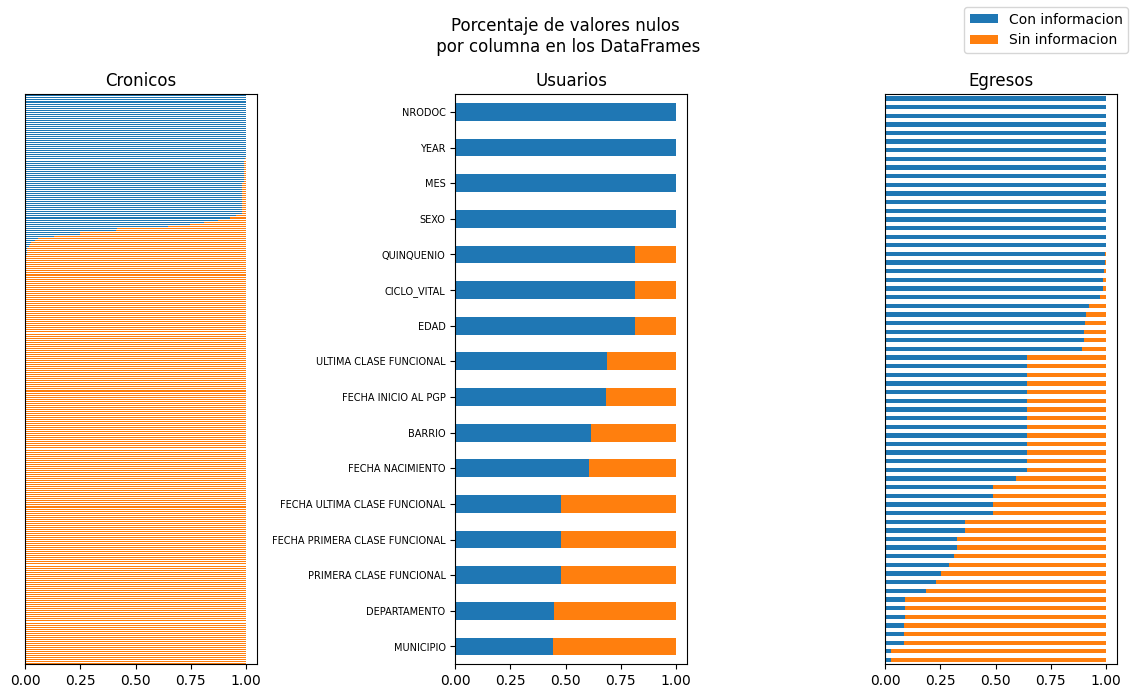

In [ ]:
# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(7*((1+np.sqrt(5))/2), 7))

# Iterar por cada base de datos
for i, j, k in zip(range(3), [df_cronicos, df_usuarios, df_egresos], ["Cronicos", "Usuarios", "Egresos"]):

  df_na = j.isna().apply(pd.Series.value_counts, normalize=True).T.fillna(0)

  df_na.sort_values(by=True, ascending=False).plot(kind="barh", stacked=True, legend=False, ax=axes[i], title=k)
  if i == 1:
    axes[i].set_yticklabels(df_na.sort_values(by=True, ascending=False).index ,fontsize=7)
  else:
    axes[i].set_yticks([])

fig.suptitle("Porcentaje de valores nulos\n por columna en los DataFrames")
fig.legend(axes[0].patch, labels=["Con informacion", "Sin informacion"])
plt.tight_layout()
plt.show()

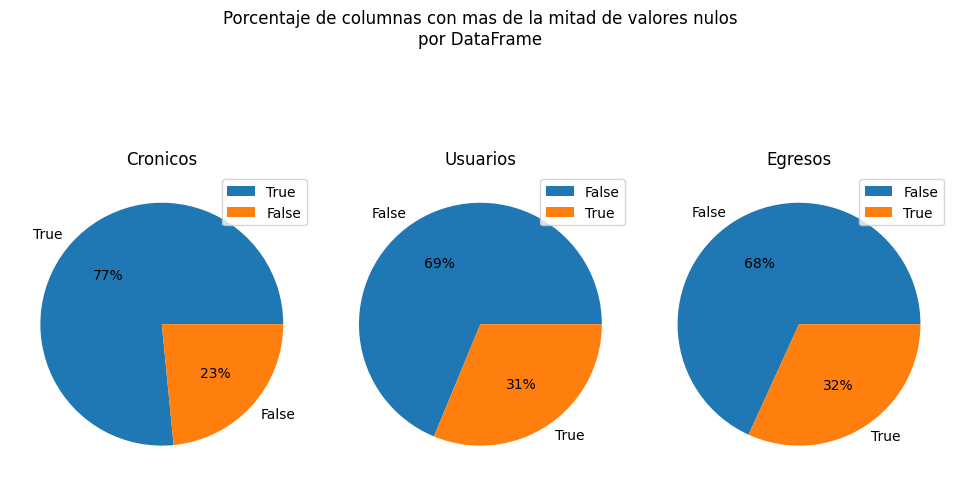

In [ ]:
# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(6*((1+np.sqrt(5))/2), 6))

# Iterar por cada base de datos
for i, j, k in zip(range(3), [df_cronicos, df_usuarios, df_egresos], ["Cronicos", "Usuarios", "Egresos"]):

  df_na = (j.isna().sum() > int(j.shape[0]/2)).value_counts()
  axes[i].pie(df_na.values, autopct="%1.0f%%", labels=[df_na.sort_values(ascending=False).index[0], df_na.sort_values(ascending=False).index[1]])
  axes[i].set_title(k)
  axes[i].legend()


fig.suptitle("Porcentaje de columnas con mas de la mitad de valores nulos\npor DataFrame")
# fig.legend(axes[0].patch, labels=["Con informacion", "Sin informacion"])
fig.tight_layout()
fig.show()

In [ ]:
wid_1 = widgets.Dropdown(options=df_cronicos.loc[:,"NRODOC"].unique().tolist())

def groupby(user):

  df = df_cronicos.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)


Dropdown(options=(311144, 308418, 308573, 307549, 307044, 309419, 308437, 308637, 308561, 308563, 310132, 3105…

Output()

# Usuarios

In [ ]:
df_usuarios_t = df_usuarios.copy()

# Columnas con el mismo valor para todos los usuarios
cols = ["FECHA NACIMIENTO", "BARRIO", "MUNICIPIO", "DEPARTAMENTO", "FECHA INICIO AL PGP", "FECHA PRIMERA CLASE FUNCIONAL", "PRIMERA CLASE FUNCIONAL"]

# Filtro de usuarios mayores de 60 años y con valores NA
mask = (df_usuarios_t["EDAD"] >= 60) | (df_usuarios_t["EDAD"].isna())

# Filtrar base de datos
df_usuarios_t = df_usuarios_t[mask]

# Convertir fechas a formato date time
df_usuarios_t["FECHA NACIMIENTO"] = pd.to_datetime(df_usuarios_t["FECHA NACIMIENTO"], format="mixed")

# Diccionario con numeros de meses
spanish_months = {"ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4,
                  "MAYO": 5, "JUNIO": 6, "JULIO": 7, "AGOSTO": 8,
                  "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12}

# Cambio de nombre a numero de mes
df_usuarios_t["MES"] = df_usuarios_t["MES"].replace(spanish_months)

# Creacion de columna datetime con la fecha de diligenciamiento del formulario
df_usuarios_t["DATE"] = pd.to_datetime((df_usuarios_t["YEAR"].astype(str) + "/" + df_usuarios_t["MES"].astype(str)), format="%Y/%m")

# Llenar valores nulos de las columnas repetidas para cada paciente
for i in df_usuarios_t["NRODOC"].unique():

    df_usuarios_t.loc[df_usuarios_t.groupby("NRODOC").get_group(i).index, cols] = df_usuarios_t.groupby("NRODOC").get_group(i)[cols].bfill().ffill()

# Indexes con valores nulos para la fecha de nacimiento
fnna_index = df_usuarios_t[df_usuarios_t["FECHA NACIMIENTO"].isna()].index

# Reemplazar los valores de la fecha de nacimiento de los index previos
for id in df_usuarios.loc[fnna_index, "NRODOC"].unique().tolist():

  df = df_usuarios_t.copy().groupby("NRODOC").get_group(id)

  edad = df["EDAD"].min()
  fecha = df["DATE"].min()
  try:

    birth = fecha - datetime.timedelta(days=edad*365.25)
    df_usuarios_t.loc[df_usuarios_t["NRODOC"] == id, "FECHA NACIMIENTO"] = df.groupby("NRODOC").get_group(id)["FECHA NACIMIENTO"].fillna(birth)

  except ValueError:
    pass

# Eliminar filas con Edad y Fecha de nacimiento nulas (no se tiene informacion del paciente)
df_usuarios_t.dropna(subset=["EDAD", "FECHA NACIMIENTO"], how="all", inplace=True)

# Modificar columna edad con resta de fecha de nacimiento y fecha de diligenciamiento del formulario
df_usuarios_t["EDAD"] = ((df_usuarios_t["DATE"] - df_usuarios_t["FECHA NACIMIENTO"])/datetime.timedelta(days=365.25)).round(0).astype(int)

# Filtro con usuarios mayores a 60 años luego de tratar valores
mask = (df_usuarios_t["EDAD"] >= 60)

# Filtrar usuarios mayores a 60 años
df_usuarios_t = df_usuarios_t[mask]

# Columnas con informacion poco relevante
to_drop = ["MES", "YEAR", "DEPARTAMENTO", "QUINQUENIO", "CICLO_VITAL", "FECHA INICIO AL PGP"]

# Eliminar columnas
df_usuarios_t.drop(to_drop, axis=1, inplace=True)

# Eliminar usuarios con Clase funcional 4 ya que son usuarios con atencion en casa
df_usuarios_t.drop(df_usuarios_t[df_usuarios_t["PRIMERA CLASE FUNCIONAL"].str.contains("4").fillna(False)].index, inplace=True)

# Reemplazar valores para sexo nulos y sin sentido, aleatoriamente
df_usuarios_t.loc[~df_usuarios_t["SEXO"].isin(["F", "M"]), "SEXO"] = [random.choice(["F", "M"]) for i in range(len(df_usuarios_t[~df_usuarios_t["SEXO"].isin(["F", "M"])]))]

# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = (df_usuarios_t.isnull().sum() / len(df_usuarios_t)) * 100

# Filtra las variables que tienen más del 10% de valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos > 10].index

# Elimina las variables con más del 10% de valores nulos del DataFrame
df_usuarios_t.drop(variables_con_nulos, axis=1, inplace=True)

<ipython-input-6-f84df5067e9a>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usuarios_t.drop(to_drop, axis=1, inplace=True)
<ipython-input-6-f84df5067e9a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usuarios_t.drop(df_usuarios_t[df_usuarios_t["PRIMERA CLASE FUNCIONAL"].str.contains("4").fillna(False)].index, inplace=True)


In [ ]:
df_usuarios_t = pd.read_csv("data/df_usuarios_t.csv", low_memory=False, parse_dates=["DATE"])

In [ ]:
wid_1 = widgets.Dropdown(options=df_usuarios["NRODOC"].unique().tolist())

def groupby(user):

  df = df_usuarios_t.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)

In [ ]:
# Usuarios mayores de 60
ids = df_usuarios_t["NRODOC"].unique()

# Cronicos

In [ ]:
df_cronicos = df_cronicos[df_cronicos["NRODOC"].isin(ids)]

In [ ]:
# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = (df_cronicos.isnull().sum() / len(df_cronicos)) * 100

# Filtra las variables con valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos > 0].index

# Elimina las variables con valores nulos del DataFrame
df_cronicos.drop(variables_con_nulos, axis=1, inplace=True)

# Modificar Fecha de diligenciamiento agregando la hora
df_cronicos["Fecha diligenciamiento"] = pd.to_datetime((df_cronicos["Fecha diligenciamiento"].astype(str) + " " + df_cronicos["Hora"].astype(str)), format="mixed")

# Eliminar columnas con informacion repetida
df_cronicos.drop(["YEAR", "MES", "Hora"], axis=1, inplace=True)

In [ ]:
df_cronicos.isna().sum()

Fecha diligenciamiento                    0
Atencion                                  0
Ingreso                                   0
Tipo                                      0
NRODOC                                    0
Peso                                      0
Talla                                     0
IMC                                       0
Clasificacion IMC                         0
Perimetro Muslo                           0
Perimetro Cintura                         0
Pliegue Triceps                           0
Pliegue Abdomen                           0
Pliegue Muslo                             0
Sumatoria Pliegues                        0
Presion Arterial Sistolica                0
Presion Arterial Diastolica               0
Frecuencia Cardiaca en reposo             0
Auto-calificacion Nivel de Ejercicio      0
Constantes                                0
METS -Indice Metabolico                   0
VO2 - Maxima Cantidad de Oxigeno          0
Calificacion (Indice de Fragilid

In [ ]:
# Obtener solo las variables numéricas
variables_numericas = df_cronicos.select_dtypes(include=['number']).columns.tolist()

# Función para visualizar boxplots de una variable numérica
def visualizar_boxplot(nombre_variable):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=nombre_variable)
    plt.title("Boxplot de la variable: {}".format(nombre_variable))
    plt.xlabel("Valor")
    plt.ylabel("Variable")
    plt.show()

# Crear lista desplegable para seleccionar variable
opciones_variables = [(variable, variable) for variable in variables_numericas]
lista_desplegable = widgets.Dropdown(options=opciones_variables, description='Variable:')

# Llamar a la función visualizar_boxplot cuando se seleccione una variable
widgets.interactive(visualizar_boxplot, nombre_variable=lista_desplegable)

interactive(children=(Dropdown(description='Variable:', options=(('YEAR', 'YEAR'), ('AtenciA3n', 'AtenciA3n'),…

In [ ]:
# Función para visualizar la distribución de una variable
def visualizar_variable(nombre_variable):
    plt.figure(figsize=(8, 6))
    # Seleccionar el tipo de gráfico según el tipo de variable
    if df_cronicos[nombre_variable].dtype == 'object':
        df_cronicos[nombre_variable].value_counts().plot(kind='pie')
    else:
        df_cronicos[nombre_variable].plot(kind='hist', bins=20)
    plt.title("Distribución de la variable: {}".format(nombre_variable))
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.show()

# Lista de variables en el DataFrame
variables = df_cronicos.columns.tolist()

# Crear lista desplegable para seleccionar variable
opciones_variables = [(variable, variable) for variable in variables]
lista_desplegable = widgets.Dropdown(options=opciones_variables, description='Variable:')

# Llamar a la función visualizar_variable cuando se seleccione una variable
widgets.interactive(visualizar_variable, nombre_variable=lista_desplegable)

interactive(children=(Dropdown(description='Variable:', options=(('YEAR', 'YEAR'), ('MES', 'MES'), ('Fecha dil…

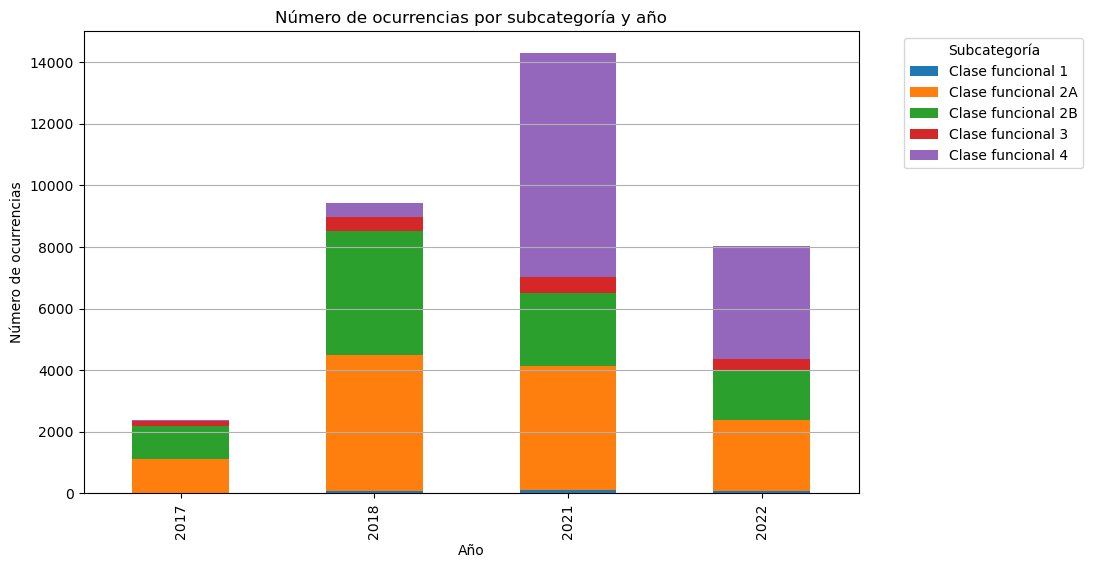

In [ ]:
# Calcular el número de ocurrencias de cada calse funcional por año
ocurrencias_por_año = df_cronicos.groupby(['YEAR', 'Clase Funcional'])['Clase Funcional'].count().unstack()

# Graficar el número de ocurrencias de cada clase funcional por año
ocurrencias_por_año.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Año')
plt.ylabel('Número de ocurrencias')
plt.title('Número de ocurrencias por subcategoría y año')
plt.legend(title='Subcategoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# Egresos

In [ ]:
df_egresos = df_egresos[df_egresos["NRODOC"].isin(ids)]

In [ ]:
# Calcula el porcentaje de valores nulos en cada variable
porcentaje_nulos = df_egresos.isna().apply(pd.Series.value_counts, normalize=True).T.fillna(0)

# Filtra las variables que tienen más del 10% de valores nulos
variables_con_nulos = porcentaje_nulos[porcentaje_nulos[True] > 0.1].index.values.tolist()

# Mantener columna de ingreso a la clinica
variables_con_nulos.remove('FECHA INGRESO CLINICA')

# Mantener columna
variables_con_nulos.remove('DX RELACIONADO3')

# Filtro de usuarios con causas de muerte registrada
mask_dead = ~df_egresos['CAUSA BASICA MUERTE COD'].isna() | ~df_egresos['CAUSA BASICA MUERTE'].isna() | ~df_egresos['CAUSA BASICA CATEGORIA COD'].isna() | ~df_egresos['CAUSA BASICA CATEGORIA'].isna() | ~df_egresos['CAUSA BASICA CAPITULO COD'].isna() | ~df_egresos['CAUSA BASICA CAPITULO'].isna()

# Eliminar usuarios con causas de muerte registrada
df_egresos.drop(df_egresos[mask_dead].index, inplace=True)

# Elimina las variables con más del 10% de valores nulos del DataFrame
df_egresos.drop(variables_con_nulos, axis=1, inplace=True)


<ipython-input-28-a500e37f5564>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_egresos.drop(df_egresos[mask_dead].index, inplace=True)
<ipython-input-28-a500e37f5564>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_egresos.drop(variables_con_nulos, axis=1, inplace=True)


In [ ]:
# Data Frame con descripciones de los codigos
causas = pd.read_excel("data/listas_de_causas.xlsx").ffill()

# Reemplazar caracteres erroneos
causas["COD_4"] = causas["COD_4"].str.replace("†", "")

# Codigos sin descripcion en la columna DXPRINCIPAL EGRESO COD
na_cod = df_egresos.loc[~df_egresos["DXPRINCIPAL EGRESO COD"].isna() & df_egresos["DXPRINCIPAL EGRESO"].isna(), "DXPRINCIPAL EGRESO COD"].unique()

# Diccionario vacio para los Codigos
dic_cod = {}

# Ciclo para obetener descripcion de los codigos
for cod in range(len(na_cod)):

  try:

    dic_cod[na_cod[cod]] = causas.loc[causas["COD_3"] == na_cod[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == na_cod[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[na_cod[cod]] = causas.loc[causas["COD_3"] == na_cod[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[na_cod[cod]] = "No clasifcado"

# DXPRINCIPAL EGRESO COD con descripion en columna DXPRINCIPAL EGRESO
full_cod = df_egresos.loc[~df_egresos["DXPRINCIPAL EGRESO"].isna(), "DXPRINCIPAL EGRESO COD"].unique()

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod)):

    dic_cod[full_cod[cod]] = df_egresos.groupby("DXPRINCIPAL EGRESO COD").get_group(full_cod[cod])["DXPRINCIPAL EGRESO"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO1 COD sin descripcion rn DX RELACIONADO1
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO1 COD"].isna() & df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO1 COD sin descripcion rn DX RELACIONADO1
cod_r1 = df_egresos.loc[~df_egresos["DX RELACIONADO1 COD"].isna() & df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r1.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r1)):

  try:

    dic_cod[cod_r1[cod]] = causas.loc[causas["COD_3"] == cod_r1[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r1[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r1[cod]] = causas.loc[causas["COD_3"] == cod_r1[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r1[cod]] = "No clasifcado"

# DX RELACIONADO1 COD con descripion en columna DX RELACIONADO1
full_cod_r1 = df_egresos.loc[~df_egresos["DX RELACIONADO1"].isna(), "DX RELACIONADO1 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r1)):
    full_cod_r1.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r1)):

    dic_cod[full_cod_r1[cod]] = df_egresos.groupby("DX RELACIONADO1 COD").get_group(full_cod_r1[cod])["DXPRINCIPAL EGRESO"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO2 COD sin descripcion rn DX RELACIONADO2
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO2 COD"].isna() & df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO2 COD sin descripcion rn DX RELACIONADO2
cod_r2 = df_egresos.loc[~df_egresos["DX RELACIONADO2 COD"].isna() & df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r2.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r2)):

  try:

    dic_cod[cod_r2[cod]] = causas.loc[causas["COD_3"] == cod_r2[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r2[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r2[cod]] = causas.loc[causas["COD_3"] == cod_r2[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r2[cod]] = "No clasifcado"

# DX RELACIONADO2 COD con descripion en columna DX RELACIONADO2
full_cod_r2 = df_egresos.loc[~df_egresos["DX RELACIONADO2"].isna(), "DX RELACIONADO2 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r2)):
    full_cod_r2.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r2)):

    dic_cod[full_cod_r2[cod]] = df_egresos.groupby("DX RELACIONADO2 COD").get_group(full_cod_r2[cod])["DX RELACIONADO2"].unique()[0]

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Conjunto con DX RELACIONADO3 COD sin descripcion rn DX RELACIONADO3
set_1 = set(df_egresos.loc[~df_egresos["DX RELACIONADO3 COD"].isna() & df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique())
# Conjunto de los codigos ya presentes en el diccionario
set_2 = set(dic_cod.keys())

# DX RELACIONADO3 COD sin descripcion rn DX RELACIONADO3
cod_r3 = df_egresos.loc[~df_egresos["DX RELACIONADO3 COD"].isna() & df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique().tolist()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set_2):
    cod_r3.remove(i)

# Ciclo para obetener descripcion de los codigos
for cod in range(len(cod_r3)):

  try:

    dic_cod[cod_r3[cod]] = causas.loc[causas["COD_3"] == cod_r3[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0] + causas.loc[causas["COD_4"] == cod_r3[cod], "DESCRIPCION CODIGOS DE CUATRO CARACTERES"].iloc[0]

  except IndexError:

    try:

      dic_cod[cod_r3[cod]] = causas.loc[causas["COD_3"] == cod_r3[cod][:-1], "DESRIPCION CATEGORIAS DE TRES CARACTERES"].iloc[0]

    except IndexError:
      # Si no se encuntra, se toma como No clasifcado
      dic_cod[cod_r3[cod]] = "No clasifcado"

# DX RELACIONADO3 COD con descripion en columna DX RELACIONADO3
full_cod_r3 = df_egresos.loc[~df_egresos["DX RELACIONADO3"].isna(), "DX RELACIONADO3 COD"].unique()

# Eliminar codigos ya presentes en el diccionario
for i in set_1.intersection(set(full_cod_r3)):
    full_cod_r3.remove(i)

# Agregar descripciones de los codigos al diccionario
for cod in range(len(full_cod_r3)):

  dic_cod[full_cod_r3[cod]] = df_egresos.groupby("DX RELACIONADO3 COD").get_group(full_cod_r3[cod])["DX RELACIONADO3"].unique()[0]

# ------------------------

# Cambiar valores de espera a segundos
df_egresos["DEMORA ASIGNACION CAMA"] = df_egresos["DEMORA ASIGNACION CAMA"].str.extract("(\d*):").astype(int)*60 + df_egresos["DEMORA ASIGNACION CAMA"].str.extract(":(\d*)").astype(int)
df_egresos["DEMORA APLICACION MEDICAMENTO"] = df_egresos["DEMORA APLICACION MEDICAMENTO"].str.extract("(\d*):").astype(float)*60 + df_egresos["DEMORA APLICACION MEDICAMENTO"].str.extract(":(\d*)").replace("", 0).astype(int)

# Columnas sin informacion relevante
to_drop = ["DXPRINCIPAL EGRESO", "DX RELACIONADO1", "DX RELACIONADO2", "DX RELACIONADO3", "DX PRINCIPAL EGRESO CATEGORIA COD", "DX PRINCIPAL EGRESO CATEGORIA",
           "DX PRINCIPAL EGRESO CAPITULO COD", "DX PRINCIPAL EGRESO CAPITULO", "TIPO IDENTIFICACION", "SERVICIO HABILITADO COD", "YEAR", "MES",
           "NRO INGRESO", "NRO ATENCION"]

# Pasar a formato fecha los valores con Fechas
for i in df_egresos.columns[df_egresos.columns.str.startswith("FECHA")]:
    df_egresos[i] = pd.to_datetime(df_egresos[i], format="mixed")

# Diccionario con numeros de meses
spanish_months = {"ENERO": 1, "FEBRERO": 2, "MARZO": 3, "ABRIL": 4,
                  "MAYO": 5, "JUNIO": 6, "JULIO": 7, "AGOSTO": 8,
                  "SEPTIEMBRE": 9, "OCTUBRE": 10, "NOVIEMBRE": 11, "DICIEMBRE": 12}

# Cambio de nombre a numero de mes
df_egresos["MES"] = df_egresos["MES"].replace(spanish_months)

# Indexes con la Fecha de ingreso con valor Nan
ind = df_egresos[df_egresos["FECHA INGRESO CLINICA"].isna()].index

# # Eliminar registros de valores nulos en la columna FECHA INGRESO CLINICA
# df_egresos.drop(ind, inplace=True)

# Completar valores nulos de FECHA INGRESO CLINICA con el primerdia del mes registrado en la columna MES
df_egresos["FECHA INGRESO CLINICA"].fillna(pd.to_datetime(df_egresos.loc[ind, "YEAR"].astype(str) + "-" + df_egresos.loc[ind, "MES"].astype(str), format="mixed"), inplace=True)

# Elimar registros con servicios de Atencion domiciliaria
df_egresos.drop(df_egresos[df_egresos["SERVICIO ADMITE"] == 'AtenciÃ³n Domiciliaria'].index, inplace=True)

# Completar valoires nulos de SERVICIO ADMITE ya que eran muy pocos se usa ffill
df_egresos["SERVICIO ADMITE"].ffill(inplace=True)

# Eliminar columnas con poca informacion
df_egresos.drop(to_drop, axis=1, inplace=True)

# Eliminar filas con codigos nulos
df_egresos.dropna(subset=["DX RELACIONADO1 COD", "DX RELACIONADO2 COD", "DX RELACIONADO3 COD"], how="any", inplace=True)

# Creacion de la Variable Objetivo (LOS)
df_egresos["LOS"] = df_egresos["FECHA SALIDA"] - df_egresos["FECHA INGRESO CLINICA"]


KeyError: 'DX RELACIONADO1'

# Cruce

In [ ]:
# Conjunto de documentos presentes en df_usuarios
set_1 = set(df_usuarios_t["NRODOC"].unique().tolist())
# Conjunto de documentos presentes en df_cronicos
set_2 = set(df_cronicos["NRODOC"].unique().tolist())
# Conjunto de documentos presentes en df_egresos
set_3 = set(df_egresos["NRODOC"].unique().tolist())
# Documentos en todos los Data Frames
set_T = set_1.intersection(set_2).intersection(set_3)

# Interseccion de los Data Frames con las variables a considerar
df_t = pd.merge(pd.merge(df_egresos , df_cronicos, on='NRODOC', how='inner'), df_usuarios_t, on="NRODOC", how="inner")

# Eliminar valores duplicados
df_t.drop_duplicates(inplace=True, subset="LOS")

wid_1 = widgets.Dropdown(options=set_T)

def groupby(user):

  df = df_t.groupby("NRODOC").get_group(user)
  display(df)

output = interactive_output(groupby, {"user":wid_1})

display(wid_1, output)

KeyError: Index(['LOS'], dtype='object')

In [ ]:
def heatmap(df=..., annot=False):
    """
    Funcion para el mapa de correlacion de las variables numericas de un Data Frame
    devuele una figura de matplotlib

    Parametros
    ------------
        df: DataFrame con la informacion a dibujar
        annot: Mostrar valores en el grafico

    """


    assert isinstance(df, pd.DataFrame), "df debe ser un Dataframe"

    corr = df.drop("NRODOC", axis=1)._get_numeric_data().corr().round(2)


    sns.heatmap(corr.abs(), annot=annot);

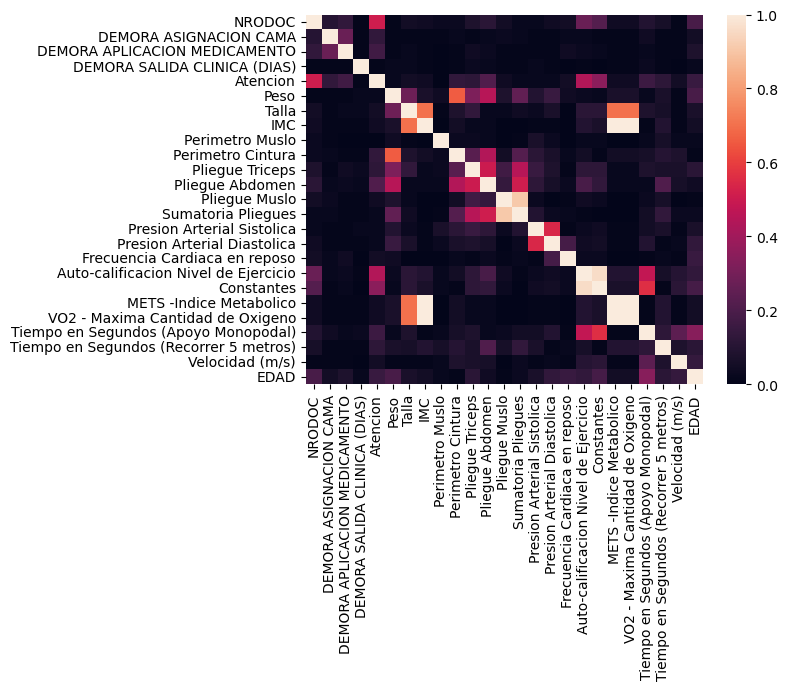

In [ ]:
heatmap(df_t)

In [ ]:
def scatterplots(feats, df=..., nrows=4, ncols=3):


    assert isinstance(df, pd.DataFrame), "df debe ser un Dataframe"

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 8))
    i = 0
    j = 0

    for x, y in itertools.combinations(feats, r=2):

        df[[x, y]].plot.scatter(x=x, y=y, ax=axes[j], xlabel=f'{x}')

        if j!=0 and j%3 == 0:
            j = 0
            i += 1
        else:
            j += 1

    fig.suptitle("Mapas de dispersion para variables de alta correlacion")
    plt.tight_layout()

In [ ]:
df_t.isna().sum()

NRODOC                                    0
FECHA NACIMIENTO_x                        0
SERVICIO ADMITE                           0
UNIDAD ESTRATEGICA                        0
FECHA INGRESO CLINICA                     0
FECHA ALTA MEDICA                         0
FECHA SALIDA                              0
DEMORA ASIGNACION CAMA                    0
DEMORA APLICACION MEDICAMENTO             0
DEMORA SALIDA CLINICA (DIAS)              0
TRANSFUSION SANGRE                        0
ANTIBIOTICO                               0
DXPRINCIPAL EGRESO COD                    0
DX RELACIONADO1 COD                       0
DX RELACIONADO2 COD                       0
DX RELACIONADO3 COD                       0
PROFESIONAL ESPECIALIDAD GRD              0
LOS                                       0
Fecha diligenciamiento                    0
Atencion                                  0
Peso                                      0
Talla                                     0
IMC                             

In [ ]:
scatterplots(["VO2 - Maxima Cantidad de Oxigeno", "IMC", "METS -Indice Metabolico"], df_t, ncols=3, nrows=1)

AssertionError: df debe ser un Dataframe